In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers, optimizers, losses, models, callbacks, metrics
import seaborn as sns
sns.set()

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 74.7MB/s]


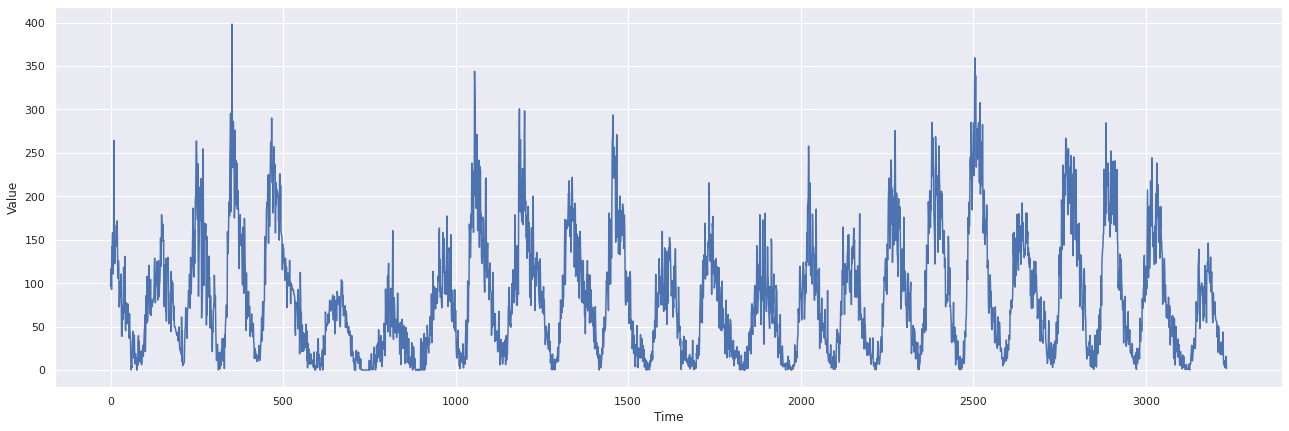

In [4]:
time_step = []
sunspots  = []

with open('/content/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)

    for row in reader:
        time_step.append(int  (row[0]))
        sunspots .append(float(row[2]))
    
series = np.array(sunspots)
time   = np.array(time_step)

split_time = 3000
time_train = time  [:split_time]
time_valid = time  [split_time:]
x_train    = series[:split_time]
x_valid    = series[split_time:]

window_size         = 60
batch_size          = 32
shuffle_buffer_size = 1000

plt.figure(figsize = (22, 7))
plot_series(time, series)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series  = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = models.Sequential([
    layers.Dense(20, input_shape = [window_size], activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1)                           
])

model.compile(loss = losses.mse,
              optimizer = optimizers.SGD(learning_rate = 1e-7, momentum = 0.9))

model.fit(dataset, epochs = 100, verbose = 0)

Error: 14.810081481933594


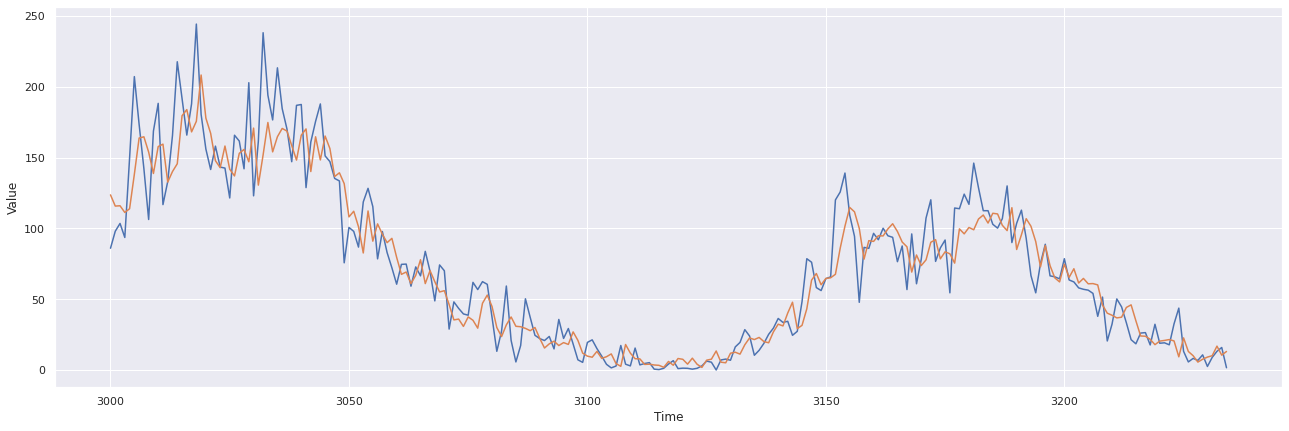

In [7]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (22, 7))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(f'Error: {metrics.mean_absolute_error(x_valid, results).numpy()}')